# Libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps, ImageEnhance
import skimage.color
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
from IPython.display import HTML
import base64

import keras


import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Activation, DepthwiseConv2D, GlobalAveragePooling2D, Add, ZeroPadding2D,
    AveragePooling2D, Concatenate
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


2024-09-09 10:03:58.342413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 10:03:58.342511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 10:03:58.518880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

In [2]:
%%time
dir = Path('/kaggle/input/covid19-pneumonia-normal-chest-xraypa-dataset-zip/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset')

filepaths = list(dir.glob(r'**/*.*'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)

CPU times: user 88.4 ms, sys: 55 ms, total: 143 ms
Wall time: 3.15 s


In [6]:
dataframe.head()

,Filepath,Label
0,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
1,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
2,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
3,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia
4,/kaggle/input/covid19-pneumonia-normal-chest-x...,pneumonia


In [7]:
# Check for null values
null_values = dataframe.isnull().sum()
print("Null values in the dataset:")
print(null_values)

Null values in the dataset:
Filepath    0
Label       0
dtype: int64


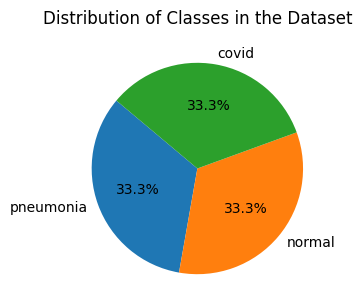

In [8]:
label_counts = dataframe['Label'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes in the Dataset\n')
plt.axis('equal')
plt.show()

We can see that the dataset is balanced

In [9]:
def plot_sample_images(df, n=5):
    plt.figure(figsize=(15, 15))
    for i, filepath in enumerate(df['Filepath'].sample(n)):
        img = load_img(filepath)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {df[df['Filepath'] == filepath]['Label'].values[0]}")
        plt.axis('off')
    plt.show()

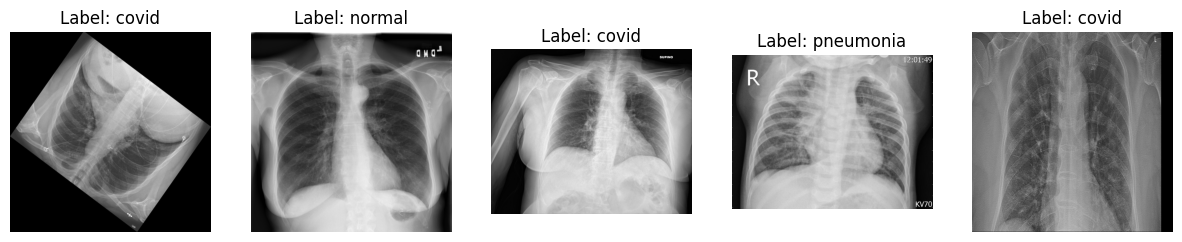

In [10]:
plot_sample_images(dataframe)

From the images ploted above we can see that we have some problems:

* They vary in size, necessitating uniform sizing.
* There's a mix of 3-channel RGB and 1-channel grayscale photos; standardizing them to grayscale is necessary.
* Images may be flipped or rotated inconsistently.

# Dataset pre-processing

For the pre-processing part: should we create differents dataset to try the different solution? We can try this approach first with the CNN that are faster than the others in their base model. I am thinking about crreate different dataset, but I will do it later. Now that I tryed the NN with the base preprocessing I achieved good results in general, now I would like to use data augmentation to avoid overfitting and reach the generalization

## Resizing

Now we are gonna do some pre-processing to our images, tu avoid problems with the models. We can start by simply resizing the images and creating a new dataset to better comparisons later.

In [3]:
def Res_image(df, save_folder, size=(224, 224), extension='png'):
    for i in range(len(df['Filepath'])):
        path = df['Filepath'][i]
        label = df['Label'][i]
        file_name = path.split('/')[-1].replace('.', '_')
        
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        
        label_dir = os.path.join(save_folder, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        save_path = os.path.join(label_dir, f"{file_name}.{extension}")
        cv2.imwrite(save_path, img.astype(np.uint8))

res_dir = Path('/kaggle/working/preprocessed_dataset_resizing')

In [4]:
%%time
Res_image(dataframe, res_dir, size=(224, 224), extension='png')

print("Preprocessing with padding completed. Preprocessed dataset saved to:", res_dir)

Preprocessing with padding completed. Preprocessed dataset saved to: /kaggle/working/preprocessed_dataset_resizing
CPU times: user 44.8 s, sys: 1.84 s, total: 46.6 s
Wall time: 1min 14s


In [5]:
%%time
filepaths = list(res_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_res = pd.concat([filepaths, labels], axis=1)

CPU times: user 73 ms, sys: 5.93 ms, total: 78.9 ms
Wall time: 77.6 ms


In [6]:
len(dataframe_res)

4575

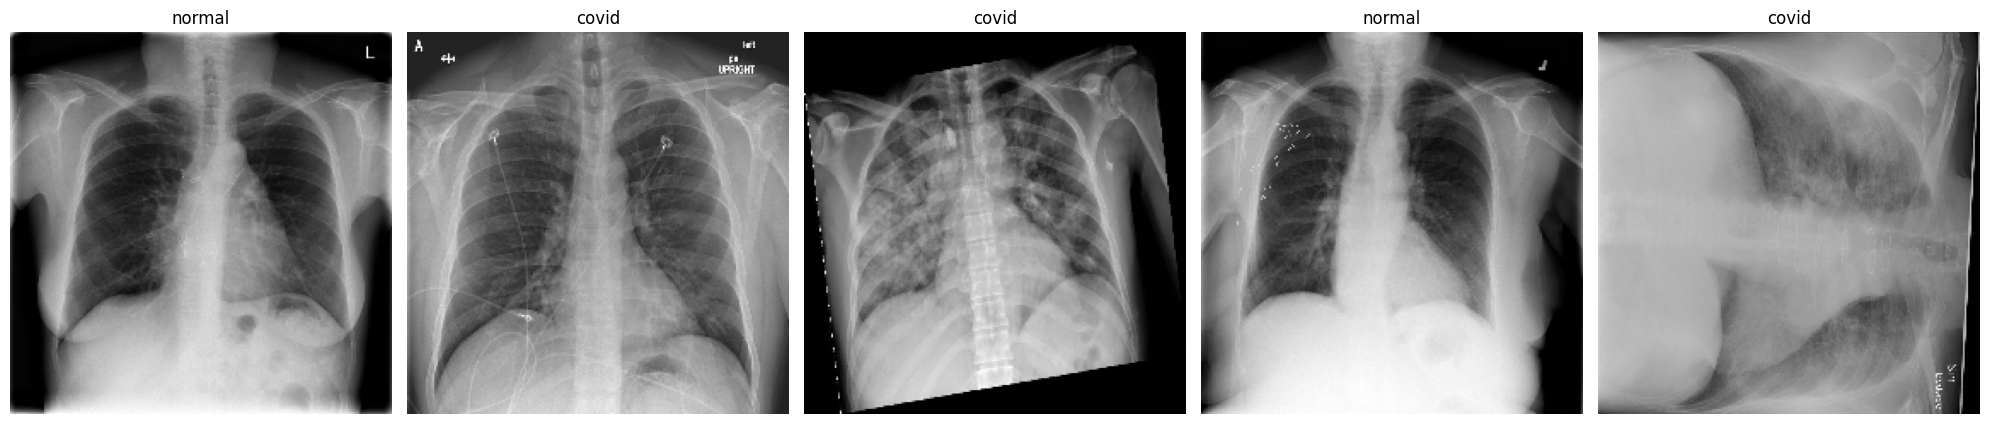

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for ax in axes:
    random_idx = np.random.randint(0, len(dataframe_res))
    img_path = dataframe_res.iloc[random_idx]['Filepath']
    label = dataframe_res.iloc[random_idx]['Label']
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Padding

Now we are gonna do the same but using padding

In [6]:
def Padd_image(df, save_folder, size=(224, 224), extension='png'):
    for i in range(len(df['Filepath'])):
        path = df['Filepath'][i]
        label = df['Label'][i]
        file_name = path.split('/')[-1].replace('.', '_')
        
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        # Add zeros to the narrow parts of the image
        height = img.shape[0]
        width = img.shape[1]
        if width > height:
            add_up = (width - height) // 2
            add_bottom = width - height - add_up
            add_left = 0
            add_right = 0
            img = cv2.copyMakeBorder(img, add_up, add_bottom, add_left,
                                     add_right, cv2.BORDER_CONSTANT, None, value=0)
        elif width < height:
            add_up = 0
            add_bottom = 0
            add_left = (height - width) // 2
            add_right = height - width - add_left
            img = cv2.copyMakeBorder(img, add_up, add_bottom, add_left,
                                     add_right, cv2.BORDER_CONSTANT, None, value=0)
        
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        
        label_dir = os.path.join(save_folder, label)
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        save_path = os.path.join(label_dir, f"{file_name}.{extension}")
        cv2.imwrite(save_path, img.astype(np.uint8))

padd_dir = '/kaggle/working/preprocessed_dataset_padding'

In [7]:
%%time
Padd_image(dataframe, padd_dir, size=(224, 224), extension='png')

print("Preprocessing with padding completed. Preprocessed dataset saved to:", padd_dir)

Preprocessing with padding completed. Preprocessed dataset saved to: /kaggle/working/preprocessed_dataset_padding
CPU times: user 43.2 s, sys: 1.14 s, total: 44.3 s
Wall time: 49.1 s


In [8]:
%%time
preprocessed_dir_padd = Path('/kaggle/working/preprocessed_dataset_padding')
filepaths = list(preprocessed_dir_padd.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_pad = pd.concat([filepaths, labels], axis=1)

CPU times: user 70 ms, sys: 9.04 ms, total: 79.1 ms
Wall time: 77.9 ms


In [20]:
len(dataframe_pad)

4575

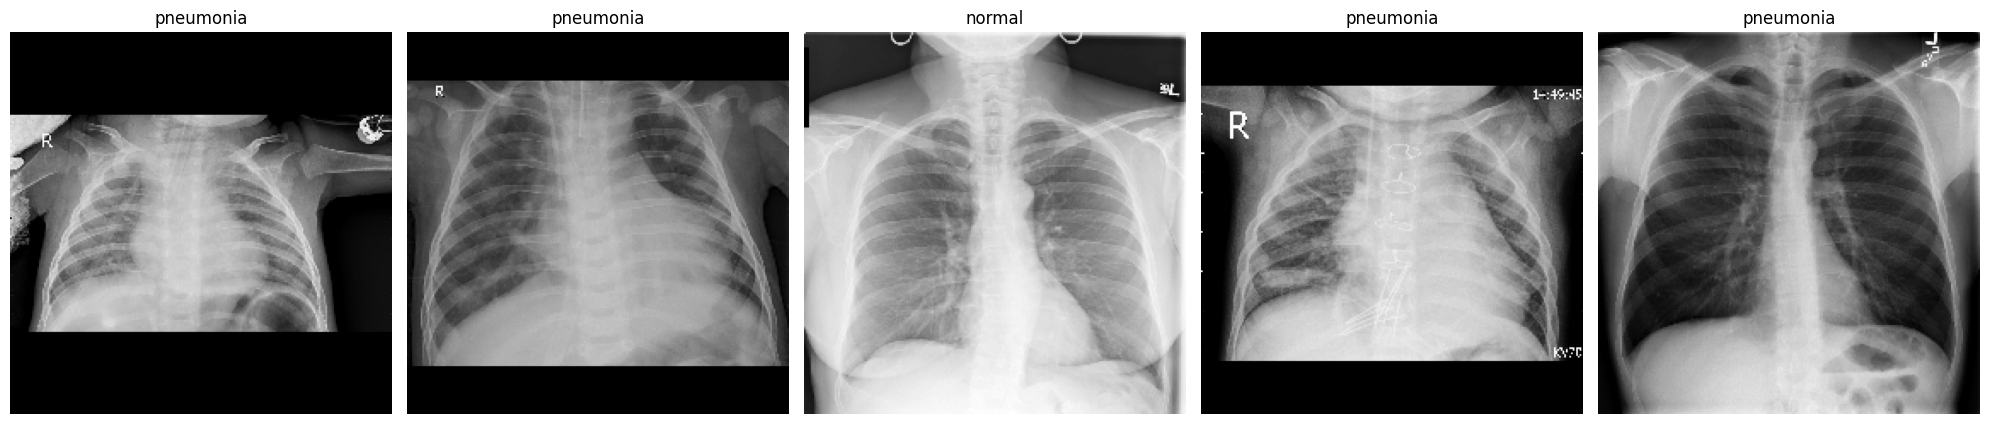

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for ax in axes:
    random_idx = np.random.randint(0, len(dataframe_pad))
    img_path = dataframe_pad.iloc[random_idx]['Filepath']
    label = dataframe_pad.iloc[random_idx]['Label']
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Dataset preparation

In [9]:
#Splitting Data into Train and Test Sets:

train_df, test_df = train_test_split(dataframe, test_size=0.2,
                                     random_state=123, 
                                     stratify=dataframe['Label'])

train_df_res, test_df_res = train_test_split(dataframe_res, test_size=0.2,
                                     random_state=123, 
                                     stratify=dataframe_res['Label'])

train_df_pad, test_df_pad = train_test_split(dataframe_pad, test_size=0.2,
                                     random_state=123, 
                                     stratify=dataframe_pad['Label'])

In [10]:
#write False to do not use the data augmentation
augmentation = False

if augmentation:
    datagen_train = ImageDataGenerator(validation_split=0.2,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       zoom_range=0.1,
                                       fill_mode='constant',
                                       cval=0,
                                       horizontal_flip=True)
else:
    datagen_train = ImageDataGenerator(validation_split=0.2)

datagen_test = ImageDataGenerator()

In [11]:
size=224
color_mode='grayscale'
batch_size=32

train_images = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=69,
    subset='training'
)

val_images = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=69,
    subset='validation'
)

test_images = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

train_images_res = datagen_train.flow_from_dataframe(
    dataframe=train_df_res,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=69,
    subset='training'
)

val_images_res = datagen_train.flow_from_dataframe(
    dataframe=train_df_res,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=69,
    subset='validation'
)

test_images_res = datagen_test.flow_from_dataframe(
    dataframe=test_df_res,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

train_images_pad = datagen_train.flow_from_dataframe(
    dataframe=train_df_pad,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=69,
    subset='training'
)

val_images_pad = datagen_train.flow_from_dataframe(
    dataframe=train_df_pad,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=69,
    subset='validation'
)

test_images_pad = datagen_test.flow_from_dataframe(
    dataframe=test_df_pad,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.
Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.
Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.


# Models implementation

## CNN

In [12]:
def build_cnn(input_shape=(224, 224, 1), n_classes=3):
    inputs = Input(shape=input_shape)
    
    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Flatten the output
    x = Flatten()(x)
    
    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

input_shape = (224, 224, 1)
n_classes = 3

model_cnn = build_cnn(input_shape=input_shape, n_classes=n_classes)

opt = keras.optimizers.Adam(learning_rate=1e-5)

model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

#model_cnn.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,771 (42.61 MB)

 Trainable params: 11,168,771 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
checkpoint_path = "/kaggle/working/cnn.keras"

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
history_cnn = model_cnn.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    batch_size=32,
    callbacks=keras_callbacks
)

In [ ]:
model_cnn.evaluate(test_images)

In [ ]:
train_accuracy_per_step = history_cnn.history['accuracy']
val_accuracy_per_step = history_cnn.history['val_accuracy']
train_loss_per_step = history_cnn.history['loss']
val_loss_per_step = history_cnn.history['val_loss']

steps_per_epoch = len(X_train) // 32

steps = range(1, len(train_accuracy_per_step) + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(steps, train_accuracy_per_step, label='Train Accuracy')
plt.plot(steps, val_accuracy_per_step, label='Validation Accuracy')
plt.title('Accuracy over Steps')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(steps, train_loss_per_step, label='Train Loss')
plt.plot(steps, val_loss_per_step, label='Validation Loss')
plt.title('Loss over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_CNN = pd.DataFrame(history_cnn.history) 

# save to csv: 
hist_CNN_csv = 'history_CNN_base.csv'
with open(hist_CNN_csv, mode='w') as f:
    hist_CNN.to_csv(f)

## DenseNet

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image, ImageOps, ImageEnhance
import skimage.color
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix, classification_report

import cv2
import os
import numpy as np
import pandas as pd
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from pathlib import Path
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, add, Flatten, Dense, DepthwiseConv2D


from tensorflow.keras.layers import MaxPool2D, Conv2D, Concatenate, GlobalAveragePooling2D, Dropout, GlobalAvgPool2D, MaxPooling2D
from tensorflow.keras.activations import relu

from keras.layers import AveragePooling2D


from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation
from keras import layers
from keras.layers import AveragePooling2D
from keras.models import Model

import pandas as pd
from collections import Counter

from IPython.display import HTML
import base64

In [14]:
def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None, name=None):
    X = BatchNormalization(axis = 3)(X_input)
    if activation is not None:
        X = Activation(activation)(X)
    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
               padding = padding)(X)
    return X


def dense_block(X, filters, repetitions):
    concat_layers = []
    concat_layers.append(X)

    for _ in range(repetitions):
        Y = conv2d_bn(X, filters=4*filters, kernel_size=(1, 1), strides=1, activation='relu')
        Y = conv2d_bn(Y, filters=filters, kernel_size=(3, 3), strides=1, activation='relu')
        concat_layers.append(Y)
        X = Concatenate()(concat_layers)

    return X

def transition_layer(X_input):
    in_channel = X_input.shape[-1] // 2
    X = conv2d_bn(X_input, filters=in_channel, kernel_size=(1, 1), strides=1, activation='relu')
    X = AveragePooling2D(pool_size=(2, 2), strides=2)(X)
    return X

def DenseNet(input_shape, filters=32, n_classes=3, repetitions=[6, 12, 24, 16]):  
    inputs = Input(input_shape)
    X = layers.Rescaling(1./255)(inputs)
    X = Conv2D(2*filters, kernel_size=(7, 7), strides=2, padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(X)
    
    for i in range(len(repetitions)-1):
        repetition = repetitions[i]
        X = dense_block(X, filters, repetition)
        X = transition_layer(X)
    repetition = repetitions[i+1]
    X = dense_block(X, filters, repetition)
        
    X = BatchNormalization(axis = 3)(X)
    X = GlobalAveragePooling2D()(X)
    if n_classes == 1:
        outputs = Dense(n_classes, activation = 'sigmoid')(X)
    else:
        outputs = Dense(n_classes, activation = 'softmax')(X)
    
    model = Model(inputs, outputs)
    return model


In [15]:
model = DenseNet(input_shape=(224, 224, 1), filters=32, n_classes=3)
#model.summary()


In [19]:
input_shape = 224, 224, 1
n_classes = 3

model_DN = DenseNet(input_shape,n_classes)

model_DN.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_503 (Conv2D) │ (None, 112, 112,  │        300 │ rescaling_7[0][0] │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         24 │ conv2d_503[0][0]  │
│ (BatchNormalizatio… │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_495      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 56, 56, 6) │          0 │ activation_495[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56, 6) │         24 │ max_pooling2d_11… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_496      │ (None, 56, 56, 6) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_504 (Conv2D) │ (None, 56, 56,    │         84 │ activation_496[0… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         48 │ conv2d_504[0][0]  │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_497      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_505 (Conv2D) │ (None, 56, 56, 3) │        327 │ activation_497[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_232     │ (None, 56, 56, 9) │          0 │ max_pooling2d_11… │
│ (Concatenate)       │                   │            │ conv2d_505[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56, 9) │         36 │ concatenate_232[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_498      │ (None, 56, 56, 9) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_506 (Conv2D) │ (None, 56, 56,    │        120 │ activation_498[0… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │         48 │ conv2d_506[0][0]  │
│ (BatchNormalizatio… │ 12)               │            │                 

 Total params: 77,529 (302.85 KB)

 Trainable params: 69,687 (272.21 KB)

 Non-trainable params: 7,842 (30.63 KB)

In [139]:
input_shape = 224, 224, 1
n_classes = 3

model_DN = DenseNet(input_shape,n_classes)
opt = keras.optimizers.Adam(learning_rate=1e-5)


model_DN.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

#model_DN_m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model_DN.summary()

#model_DN.summary()

In [ ]:
checkpoint_path = "/kaggle/working/DN.keras"

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=100, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
history_DN = model_DN.fit(
    train_images,
    epochs=100, #100
    batch_size=32,
    validation_data=val_images,
    callbacks=keras_callbacks
)

In [ ]:
model_DN.evaluate(test_images)

In [ ]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_DN.history['accuracy'], label='Train Accuracy')
plt.plot(history_DN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_DN.history['loss'], label='Train Loss')
plt.plot(history_DN.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_DN = pd.DataFrame(history_DN.history) 

# save to csv: 
hist_DN_csv = 'history_DN_base.csv'
with open(hist_DN_csv, mode='w') as f:
    hist_DN.to_csv(f)

In [ ]:
'''
#i'm trying to load a model that I saved

from tensorflow.keras.models import load_model

model_saved_dn = load_model('/kaggle/input/model_dn_2.h5/keras/default/1/model_DN_2.h5')
scores = model_saved_dn.evaluate(X_test, y_test, verbose=1)
print(f'Score: {model_saved_dn.metrics_names[0]} of {scores[0]}; {model_saved_dn.metrics_names[1]} of {scores[1]*100}%')
'''

In [ ]:
'''
#i'm trying to load a model that I saved

from tensorflow.keras.models import load_model

model_saved_dn_2 = load_model('/kaggle/input/model_dn.h5/keras/default/1/model_DN.h5')
scores = model_saved_dn_2.evaluate(X_test, y_test, verbose=1)
print(f'Score: {model_saved_dn_2.metrics_names[0]} of {scores[0]}; {model_saved_dn_2.metrics_names[1]} of {scores[1]*100}%')
'''

In [ ]:
#it works

With the DenseNet we achieved quiet good results, but the problem is that they are not good as CNN and ResNet. With this model we have problem in generalization: we have really good result in training fase but bad in general during validation and test. For the test phase we have only 915 images, maybe we need more images. Some Ideas? er could use data augmentation to add more data at the beggining or some other methods.

## ResNet

In [16]:
def resnet(size=224, num_classes=3):
    def identity_block(X, kernel_size, num_channels):    
        C1, C2 = num_channels
        X_shortcut = X

        X = Conv2D(filters=C1, kernel_size=1, strides=1, padding='valid')(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        X = Conv2D(filters=C1, kernel_size=kernel_size, strides=1, padding='same')(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        X = Conv2D(filters=C2, kernel_size=1, strides=1, padding='valid')(X)
        X = BatchNormalization(axis=3)(X)

        X = layers.add([X, X_shortcut])
        X = Activation('relu')(X)

        return X

    def convolutional_block(X, kernel_size, num_channels, stride=2):
        C1, C2 = num_channels
        X_shortcut = X

        X = Conv2D(C1, 1, strides=stride)(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        X = Conv2D(C1, kernel_size, strides=1, padding='same')(X)
        X = BatchNormalization(axis=3)(X)
        X = Activation('relu')(X)

        X = Conv2D(C2, 1, strides=1, padding='same')(X)
        X = BatchNormalization(axis=3)(X)

        X_shortcut = Conv2D(C2, 1, strides=stride)(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut)

        X = layers.add([X, X_shortcut])
        X = Activation('relu')(X)

        return X

    X_input = Input((size, size, 1))
    X = layers.Rescaling(1./255)(X_input) 
    X = ZeroPadding2D((3, 3))(X)
    
    X = Conv2D(64, 7, strides=3)(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(3, strides=2)(X)

    X = convolutional_block(X, 3, [64, 128], stride=1)
    X = identity_block(X, 3, [64, 128])

    X = convolutional_block(X, 3, [128, 256], stride=2)
    X = identity_block(X, 3, [128, 256])
    
    X = AveragePooling2D(pool_size=2)(X)

    X = Flatten()(X)
    X = Dense(num_classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X)
    
    return model

In [17]:
model_RN = resnet()

#model_RN.summary()

In [142]:
model_RN = resnet()

opt = keras.optimizers.Adam(learning_rate=1e-5)

#model_RN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model_RN.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

In [35]:
checkpoint_path = "/kaggle/working/RN.keras"

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [ ]:
# Train the model
history_RN = model_RN.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    batch_size=32,
    callbacks=keras_callbacks
)

#I tryed with adam optimizer but i had problems with generalisation, so i decided
#to use SGD/adamW to have better generalization
#with this Resnet I have generalisation problem, I have overfitting problem.
#what should I do? more epochs? we can try to save only the best model during the training.

In [ ]:
model_RN.evaluate(test_images)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_RN.history['accuracy'], label='Train Accuracy')
plt.plot(history_RN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_RN.history['loss'], label='Train Loss')
plt.plot(history_RN.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_RN = pd.DataFrame(history_RN.history) 

# save to csv: 
hist_RN_csv = 'history_RN_base.csv'
with open(hist_RN_csv, mode='w') as f:
    hist_RN.to_csv(f)

# Resized Dataset

## CNN


In [18]:
input_shape = (224, 224, 1)
n_classes = 3

model_cnn = build_cnn(input_shape=input_shape, n_classes=n_classes)

opt = keras.optimizers.Adam(learning_rate=1e-6)

model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

#model_cnn.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model_cnn.summary()

checkpoint_path = "/kaggle/working/cnn_l.keras"

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=100, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [20]:
history_cnn = model_cnn.fit(
    train_images_res,
    validation_data=val_images_res,
    epochs=100,
    batch_size=32,
    callbacks=keras_callbacks
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 3/92 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - Precision: 0.3698 - Recall: 0.3698 - accuracy: 0.3698 - auc_1: 0.5210 - loss: 23.4441 

I0000 00:00:1725876422.166679     126 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725876422.189414     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - Precision: 0.4063 - Recall: 0.4056 - accuracy: 0.4056 - auc_1: 0.5638 - loss: 10.5069

W0000 00:00:1725876433.310274     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - Precision: 0.4073 - Recall: 0.4065 - accuracy: 0.4066 - auc_1: 0.5646 - loss: 10.4316 - val_Precision: 0.7643 - val_Recall: 0.7486 - val_accuracy: 0.7568 - val_auc_1: 0.8967 - val_loss: 0.8310
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - Precision: 0.5956 - Recall: 0.5822 - accuracy: 0.5882 - auc_1: 0.7537 - loss: 2.1491 - val_Precision: 0.7908 - val_Recall: 0.7541 - val_accuracy: 0.7746 - val_auc_1: 0.9149 - val_loss: 0.6160
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - Precision: 0.6978 - Recall: 0.6469 - accuracy: 0.6780 - auc_1: 0.8416 - loss: 0.9185 - val_Precision: 0.8628 - val_Recall: 0.7473 - val_accuracy: 0.8087 - val_auc_1: 0.9275 - val_loss: 0.5561
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - Precision: 0.7602 - Recall: 0.6512 - accuracy: 0.7068 - auc_1: 0.8673 - loss: 0.7712 - val_Precision: 0.8377 - val_Recall: 0.6913 - val_accuracy: 0.7705 - val_auc_1: 0.9238 - val_loss: 0.5639
Epoch 5/100
92/92 ━━━━━━━

In [23]:
model_cnn.evaluate(test_images_res)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - Precision: 0.9272 - Recall: 0.9067 - accuracy: 0.9234 - auc_1: 0.9755 - loss: 0.2865


[0.28407347202301025,
 0.9213114976882935,
 0.9285714030265808,
 0.9092895984649658,
 0.9759185314178467]

In [146]:
# Access the class labels from the iterator
class_indices = test_images_res.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Access the class labels for all images
class_labels_list = test_images_res.classes

# Count occurrences of each class label
label_counts = Counter(class_labels_list)

# Print the counts for each class
for class_index, count in label_counts.items():
    class_name = class_labels[class_index]
    print(f"Class {class_name}: {count} images")


Class pneumonia: 305 images
Class normal: 305 images
Class covid: 305 images


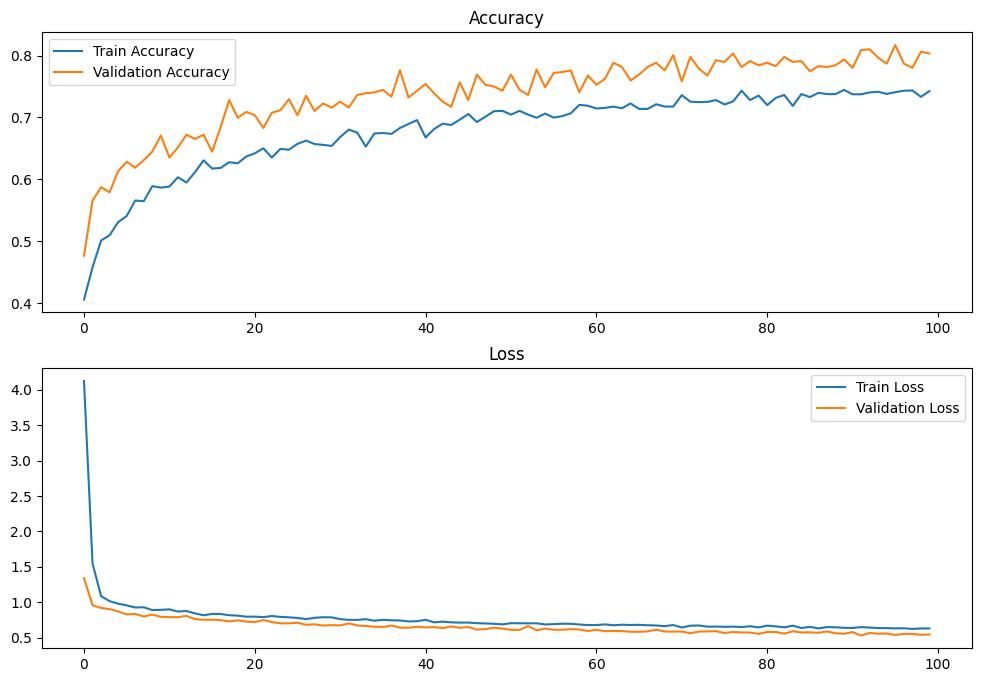

In [147]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


 6/29 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

W0000 00:00:1725212729.307804    1539 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


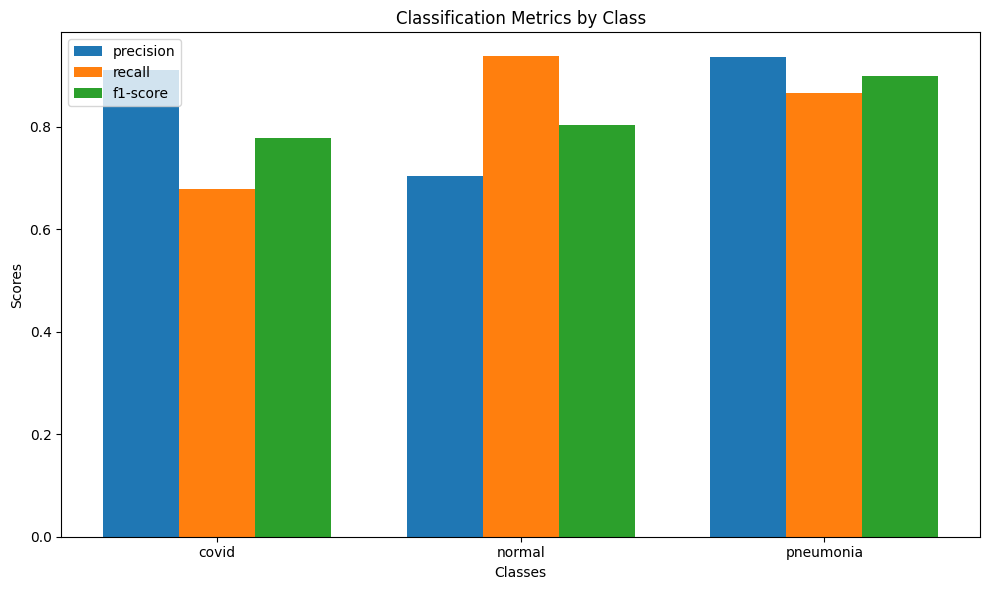

In [148]:
y_pred = model_cnn.predict(test_images_res)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(test_images_res.classes)

report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
classes = ['covid', 'normal', 'pneumonia']
metrics = ['precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for metric in metrics:
    for cls in classes:
        metrics_values[metric].append(report[cls][metric])

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metrics_values[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [149]:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_CNN = pd.DataFrame(history_cnn.history) 

# save to csv: 
hist_CNN_csv = 'history_CNN_res.csv'
with open(hist_CNN_csv, mode='w') as f:
    hist_CNN.to_csv(f)

## DenseNet

In [ ]:
input_shape = 224, 224, 1
n_classes = 3

model_DN = DenseNet(input_shape,n_classes)

In [24]:
model_DN = DenseNet(input_shape=(224, 224, 1), filters=32, n_classes=3)
opt = keras.optimizers.Adam(learning_rate=1e-5) #0.000001


model_DN.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

#model_DN_m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model_DN.summary()

#model_DN.summary()

checkpoint_path = "/kaggle/working/DN_res_l.keras"

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [25]:
history_Dn_2 = model_DN.fit(
    train_images_res,
    epochs=100, #100
    batch_size=32,
    validation_data=val_images_res,
    callbacks=keras_callbacks
)

Epoch 1/100


W0000 00:00:1725878330.505705     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.7537 - Recall: 0.4219 - accuracy: 0.6550 - auc_3: 0.8006 - loss: 0.8359

W0000 00:00:1725878453.527514     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725878460.251022     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - Precision: 0.7545 - Recall: 0.4237 - accuracy: 0.6559 - auc_3: 0.8015 - loss: 0.8344 - val_Precision: 0.3306 - val_Recall: 0.3306 - val_accuracy: 0.3306 - val_auc_3: 0.5134 - val_loss: 1.1966
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - Precision: 0.8775 - Recall: 0.7881 - accuracy: 0.8432 - auc_3: 0.9480 - loss: 0.4796 - val_Precision: 0.3306 - val_Recall: 0.3306 - val_accuracy: 0.3306 - val_auc_3: 0.4692 - val_loss: 1.4592
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 339ms/step - Precision: 0.9113 - Recall: 0.8731 - accuracy: 0.8923 - auc_3: 0.9703 - loss: 0.3557 - val_Precision: 0.2643 - val_Recall: 0.1708 - val_accuracy: 0.3197 - val_auc_3: 0.4723 - val_loss: 1.2419
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - Precision: 0.9240 - Recall: 0.9029 - accuracy: 0.9132 - auc_3: 0.9796 - loss: 0.2869 - val_Precision: 0.3501 - val_Recall: 0.2664 - val_accuracy: 0.3306 - val_auc_3: 0.4513 - val_loss: 1.4331
Epoch 5/100
92/92 ━━━━

In [26]:
model_DN.evaluate(test_images_res)

29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 624ms/step - Precision: 0.9430 - Recall: 0.9394 - accuracy: 0.9432 - auc_3: 0.9799 - loss: 0.3022


W0000 00:00:1725879724.676670     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.31178727746009827,
 0.9453551769256592,
 0.9452354907989502,
 0.9431694149971008,
 0.9786013960838318]

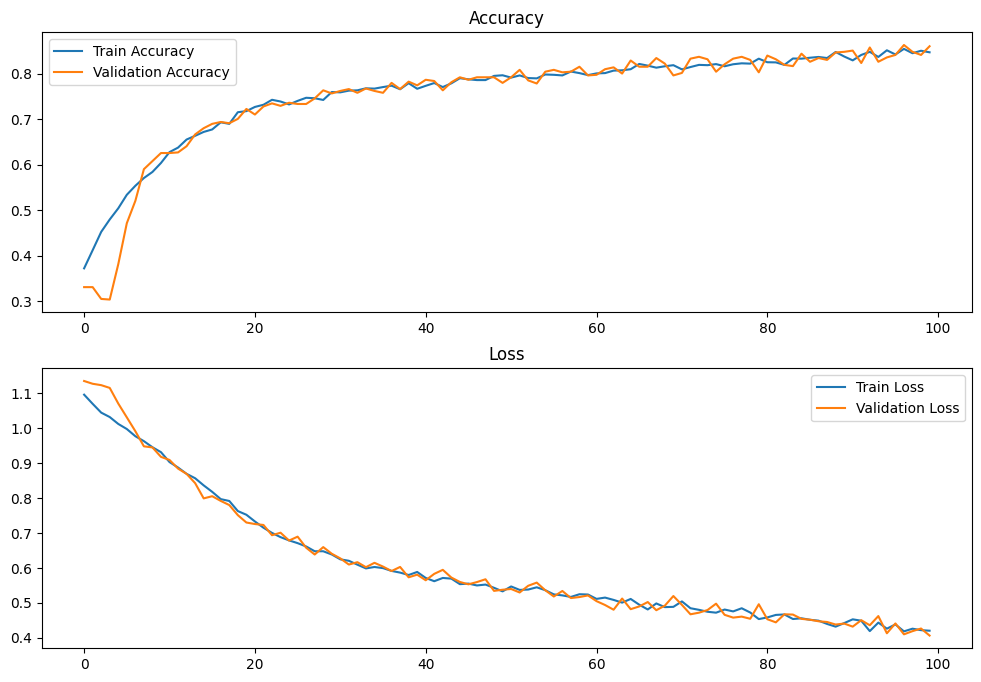

In [153]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_Dn_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_Dn_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_Dn_2.history['loss'], label='Train Loss')
plt.plot(history_Dn_2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step


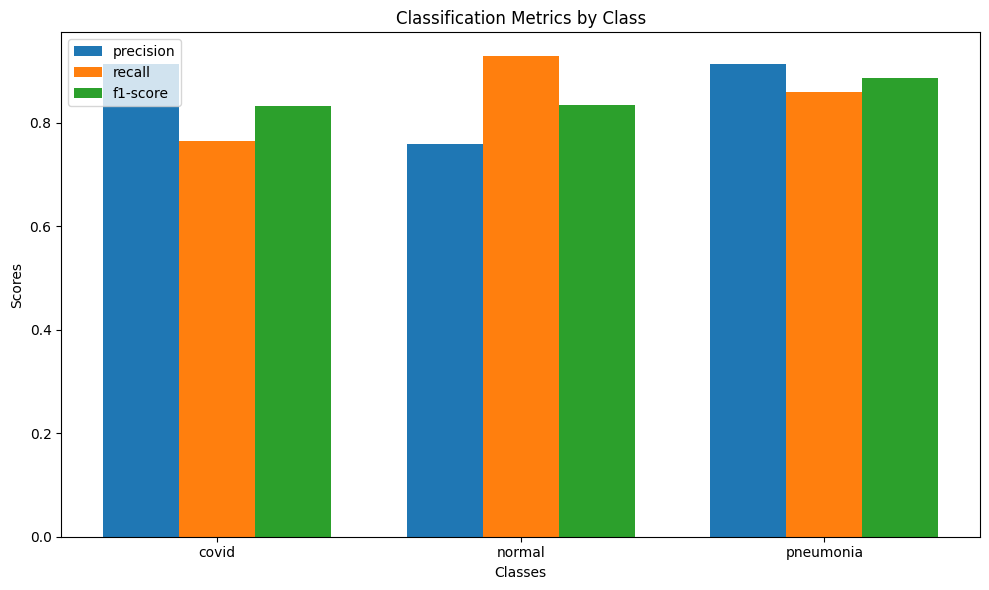

In [154]:
y_pred = model_DN.predict(test_images_res)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(test_images_res.classes)

report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
classes = ['covid', 'normal', 'pneumonia']
metrics = ['precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for metric in metrics:
    for cls in classes:
        metrics_values[metric].append(report[cls][metric])

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metrics_values[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [155]:
#history = model.fit(x_train, y_train, epochs=10)

# convert the history.history dict to a pandas DataFrame:     
hist_DN = pd.DataFrame(history_Dn_2.history)

# save to csv: 
hist_DN_csv = 'history_DN_res_1.csv'
with open(hist_DN_csv, mode='w') as f:
    hist_DN.to_csv(f)

## ResNet

In [27]:
model_RN = resnet()

opt = keras.optimizers.Adam(learning_rate=1e-5)

#model_RN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model_RN.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

checkpoint_path = "/kaggle/working/RN_res_l.keras"

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [28]:
# Train the model
history_RN = model_RN.fit(
    train_images_res,
    validation_data=val_images_res,
    epochs=100,
    batch_size=32,
    callbacks=keras_callbacks
)

#I tryed with adam optimizer but i had problems with generalisation, so i decided
#to use SGD/adamW to have better generalization
#with this Resnet I have generalisation problem, I have overfitting problem.
#what should I do? more epochs? we can try to save only the best model during the training.

Epoch 1/100
 4/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - Precision: 0.2158 - Recall: 0.2018 - accuracy: 0.2370 - auc_4: 0.3820 - loss: 2.3144

W0000 00:00:1725879746.308208     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - Precision: 0.4322 - Recall: 0.3255 - accuracy: 0.4289 - auc_4: 0.5991 - loss: 1.3143

W0000 00:00:1725879761.690519     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 208ms/step - Precision: 0.4343 - Recall: 0.3272 - accuracy: 0.4306 - auc_4: 0.6008 - loss: 1.3104 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3224 - val_auc_4: 0.4731 - val_loss: 1.2015
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - Precision: 0.8562 - Recall: 0.7799 - accuracy: 0.8275 - auc_4: 0.9342 - loss: 0.5120 - val_Precision: 0.3117 - val_Recall: 0.2623 - val_accuracy: 0.3101 - val_auc_4: 0.5115 - val_loss: 1.3939
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - Precision: 0.9110 - Recall: 0.8679 - accuracy: 0.8867 - auc_4: 0.9660 - loss: 0.3659 - val_Precision: 0.3207 - val_Recall: 0.3128 - val_accuracy: 0.3238 - val_auc_4: 0.5025 - val_loss: 1.4213
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - Precision: 0.9124 - Recall: 0.8720 - accuracy: 0.8899 - auc_4: 0.9705 - loss: 0.3358 - val_Precision: 0.3638 - val_Recall: 0.3320 - val_accuracy: 0.3525 - val_auc_4: 0.5287 - val_loss: 1.4944
Epoch 5/100
92/92 

In [29]:
model_RN.evaluate(test_images_res)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - Precision: 0.9464 - Recall: 0.9392 - accuracy: 0.9397 - auc_4: 0.9820 - loss: 0.2225


[0.23853342235088348,
 0.9377049207687378,
 0.9427312612533569,
 0.9355190992355347,
 0.9801164269447327]

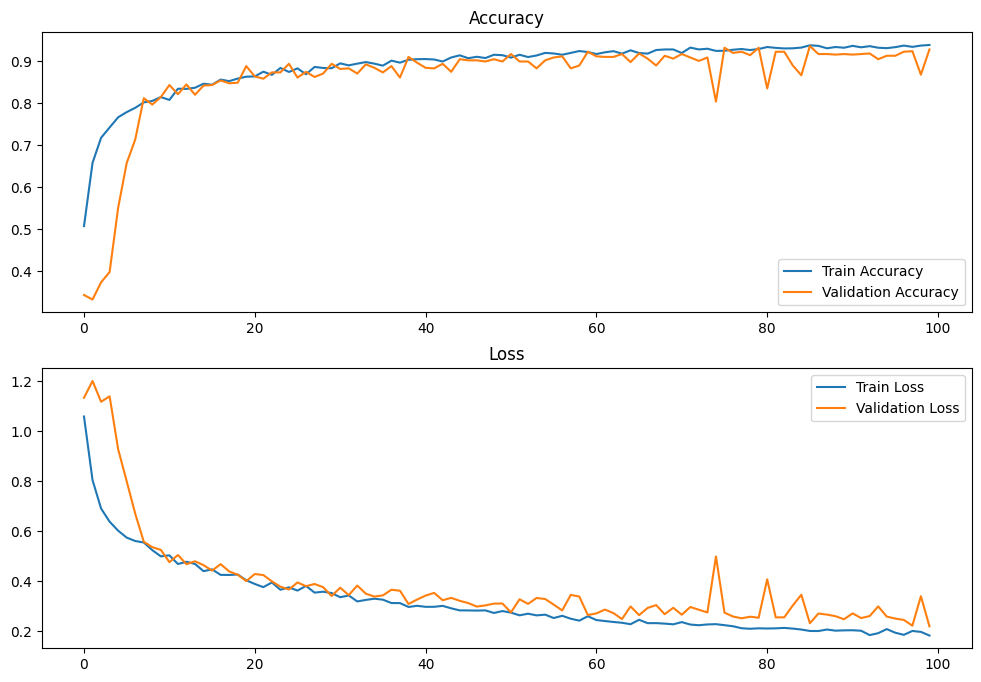

In [159]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_RN.history['accuracy'], label='Train Accuracy')
plt.plot(history_RN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_RN.history['loss'], label='Train Loss')
plt.plot(history_RN.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


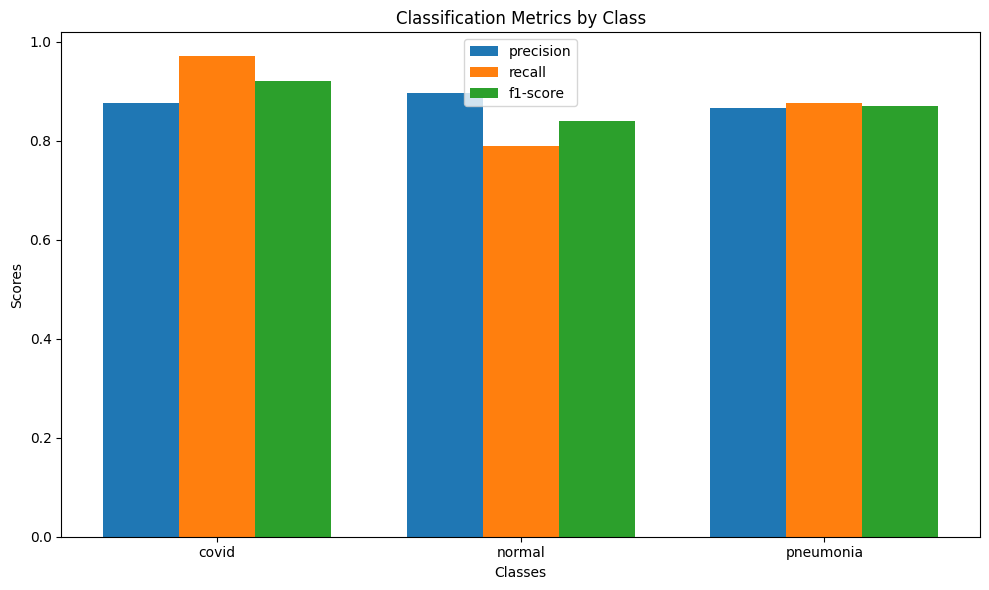

In [160]:
y_pred = model_RN.predict(test_images_res)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(test_images_res.classes)

report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
classes = ['covid', 'normal', 'pneumonia']
metrics = ['precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for metric in metrics:
    for cls in classes:
        metrics_values[metric].append(report[cls][metric])

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metrics_values[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [161]:
#history = model.fit(x_train, y_train, epochs=10)

hist_RN = pd.DataFrame(history_RN.history) 

# save to csv: 
hist_RN_csv = 'history_RN_res.csv'
with open(hist_RN_csv, mode='w') as f:
    hist_RN.to_csv(f)

# Padded Dataset

## CNN

In [30]:
input_shape = (224, 224, 1)
n_classes = 3

model_cnn = build_cnn(input_shape=input_shape, n_classes=n_classes)

opt = keras.optimizers.Adam(learning_rate=1e-6)

model_cnn.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

#model_cnn.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model_cnn.summary()

checkpoint_path = "/kaggle/working/cnn_pad_l.keras"

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [31]:
history_cnn = model_cnn.fit(
    train_images_pad,
    validation_data=val_images_pad,
    epochs=100,
    batch_size=32,
    callbacks=keras_callbacks
)

Epoch 1/100
 3/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - Precision: 0.2552 - Recall: 0.2552 - accuracy: 0.2552 - auc_5: 0.4530 - loss: 20.5847

W0000 00:00:1725880037.042194     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - Precision: 0.3844 - Recall: 0.3831 - accuracy: 0.3844 - auc_5: 0.5530 - loss: 9.2661

W0000 00:00:1725880044.345987     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - Precision: 0.3853 - Recall: 0.3840 - accuracy: 0.3853 - auc_5: 0.5539 - loss: 9.2307 - val_Precision: 0.7334 - val_Recall: 0.7254 - val_accuracy: 0.7309 - val_auc_5: 0.8685 - val_loss: 1.1352
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - Precision: 0.6183 - Recall: 0.6112 - accuracy: 0.6154 - auc_5: 0.7824 - loss: 2.0044 - val_Precision: 0.7720 - val_Recall: 0.7445 - val_accuracy: 0.7582 - val_auc_5: 0.9007 - val_loss: 0.6674
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - Precision: 0.7133 - Recall: 0.6771 - accuracy: 0.6976 - auc_5: 0.8557 - loss: 0.9232 - val_Precision: 0.7938 - val_Recall: 0.7363 - val_accuracy: 0.7732 - val_auc_5: 0.9195 - val_loss: 0.5539
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - Precision: 0.7669 - Recall: 0.6956 - accuracy: 0.7393 - auc_5: 0.8846 - loss: 0.6955 - val_Precision: 0.8058 - val_Recall: 0.7541 - val_accuracy: 0.7896 - val_auc_5: 0.9258 - val_loss: 0.5270
Epoch 5/100
92/92 ━━━━━━━━━

In [32]:
model_cnn.evaluate(test_images_res)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - Precision: 0.7537 - Recall: 0.7314 - accuracy: 0.7436 - auc_5: 0.9042 - loss: 0.6633


[0.6903640627861023,
 0.7409836053848267,
 0.748314619064331,
 0.7278688549995422,
 0.8998841047286987]

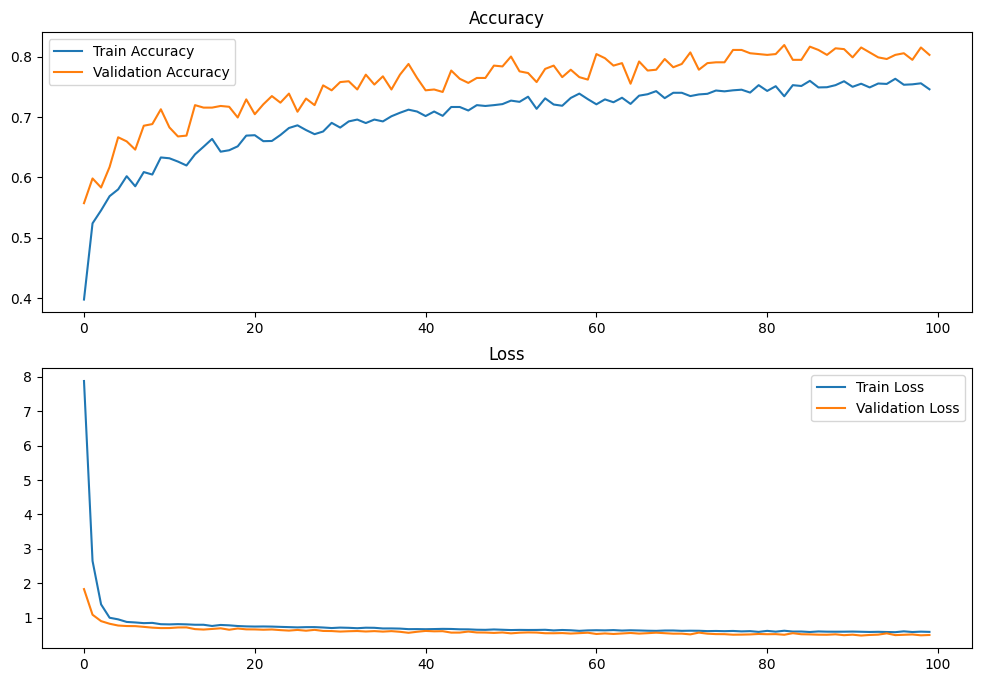

In [165]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

 8/29 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

W0000 00:00:1725217612.468988    1539 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


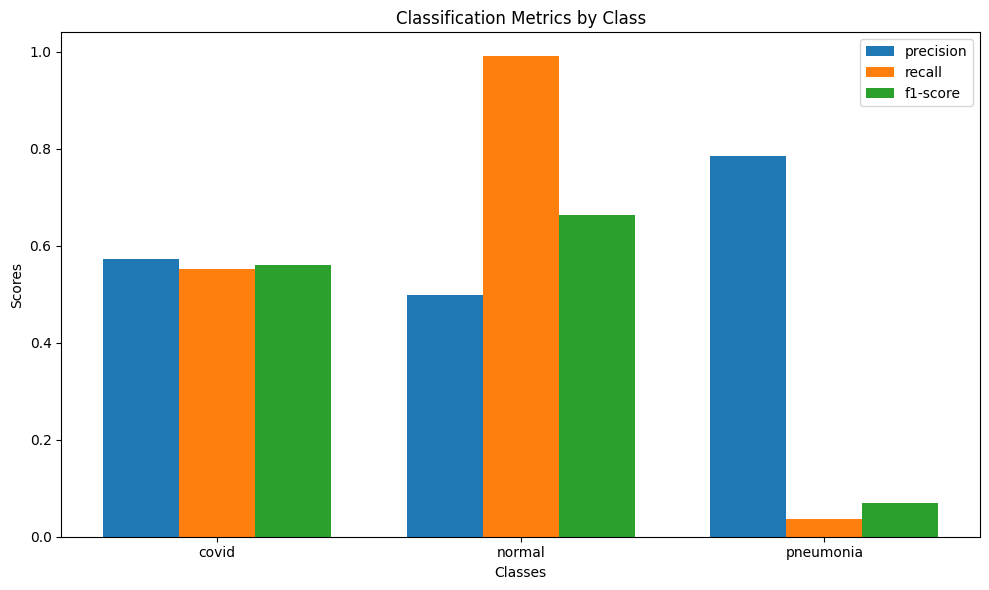

In [166]:
y_pred = model_cnn.predict(test_images_res)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(test_images_res.classes)

report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
classes = ['covid', 'normal', 'pneumonia']
metrics = ['precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for metric in metrics:
    for cls in classes:
        metrics_values[metric].append(report[cls][metric])

x = np.arange(len(classes))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metrics_values[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [167]:
#history = model.fit(x_train, y_train, epochs=10)

hist_CNN = pd.DataFrame(history_cnn.history) 

hist_CNN_csv = 'history_CNN.csv'
with open(hist_CNN_csv, mode='w') as f:
    hist_CNN.to_csv(f)

## DenseNet

In [ ]:
input_shape = 224, 224, 1
n_classes = 3

model_DN = DenseNet(input_shape,n_classes)


In [33]:
input_shape = 224, 224, 1
n_classes = 3

model_DN = DenseNet(input_shape=(224, 224, 1), filters=32, n_classes=3)
opt = keras.optimizers.Adam(learning_rate=1e-5)


model_DN.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])

#model_DN_m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model_DN.summary()

#model_DN.summary()
checkpoint_path = "/kaggle/working/DN_pad.keras"

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [34]:
history_DN = model_DN.fit(
    train_images_pad,
    epochs=100, #100
    batch_size=32,
    validation_data=val_images_pad,
    callbacks=keras_callbacks
)

Epoch 1/100


W0000 00:00:1725880708.989808     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.7675 - Recall: 0.5330 - accuracy: 0.6900 - auc_6: 0.8401 - loss: 0.7571

W0000 00:00:1725880813.788340     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725880820.546846     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - Precision: 0.7681 - Recall: 0.5346 - accuracy: 0.6909 - auc_6: 0.8409 - loss: 0.7555 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3347 - val_auc_6: 0.5169 - val_loss: 1.2201
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - Precision: 0.8815 - Recall: 0.8297 - accuracy: 0.8616 - auc_6: 0.9558 - loss: 0.4174 - val_Precision: 0.6667 - val_Recall: 0.0027 - val_accuracy: 0.3347 - val_auc_6: 0.4826 - val_loss: 1.3436
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 341ms/step - Precision: 0.8920 - Recall: 0.8701 - accuracy: 0.8824 - auc_6: 0.9689 - loss: 0.3484 - val_Precision: 0.3248 - val_Recall: 0.2937 - val_accuracy: 0.3402 - val_auc_6: 0.5164 - val_loss: 1.2297
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - Precision: 0.9124 - Recall: 0.8909 - accuracy: 0.9017 - auc_6: 0.9781 - loss: 0.2936 - val_Precision: 0.2628 - val_Recall: 0.2309 - val_accuracy: 0.2623 - val_auc_6: 0.4794 - val_loss: 1.6252
Epoch 5/100
92

In [35]:
model_DN.evaluate(test_images_pad)

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - Precision: 0.9090 - Recall: 0.9085 - accuracy: 0.9086 - auc_6: 0.9779 - loss: 0.3441


W0000 00:00:1725882228.176443     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.36106953024864197,
 0.916939914226532,
 0.9178532361984253,
 0.9158470034599304,
 0.9757881760597229]

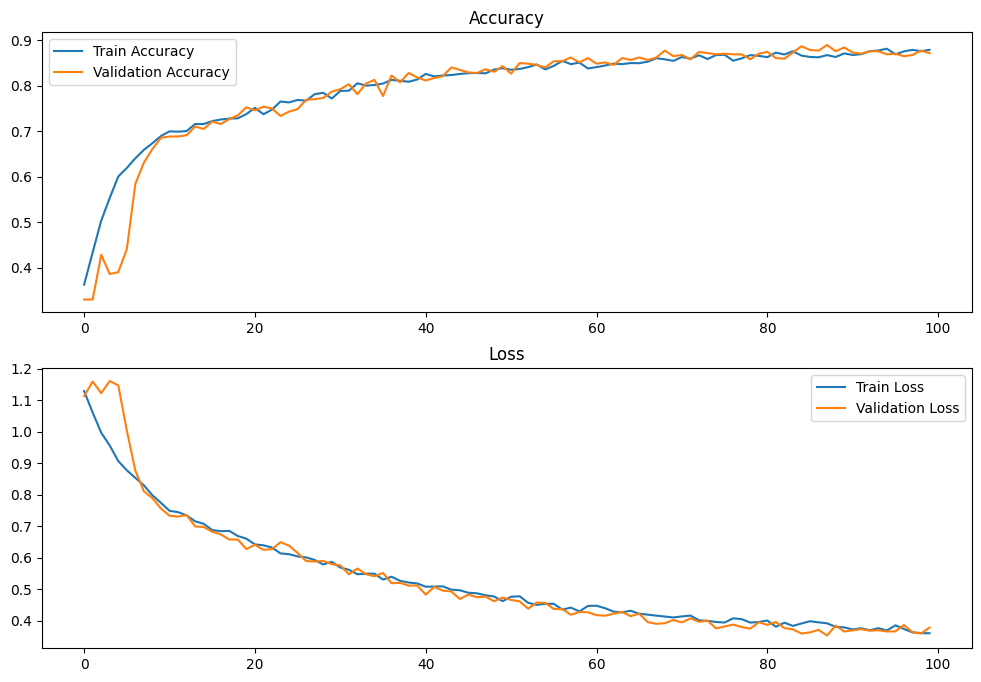

In [172]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_DN.history['accuracy'], label='Train Accuracy')
plt.plot(history_DN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_DN.history['loss'], label='Train Loss')
plt.plot(history_DN.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 341ms/step


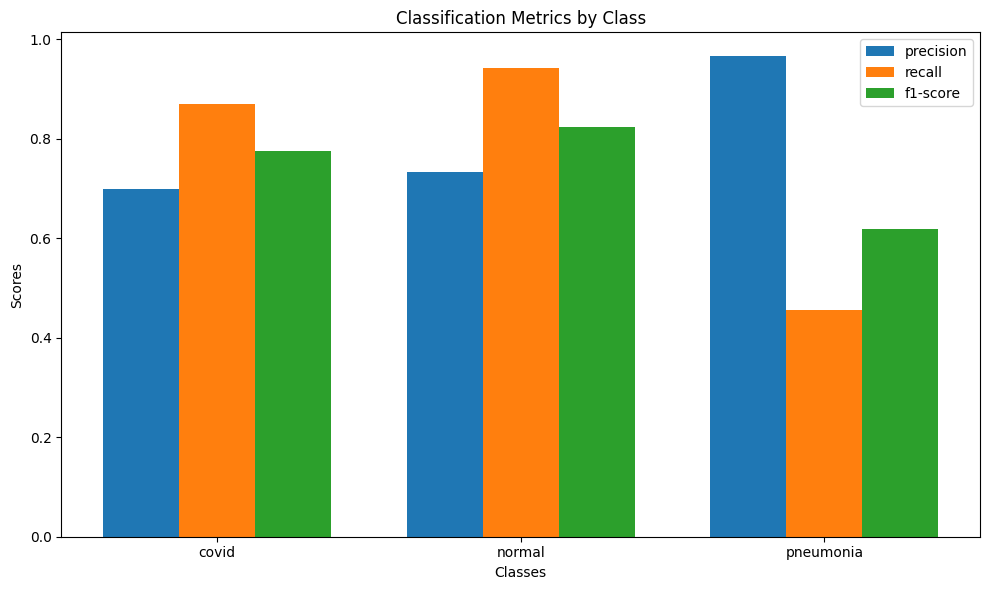

In [173]:
y_pred = model_DN.predict(test_images_res)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(test_images_res.classes)

report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
classes = ['covid', 'normal', 'pneumonia']
metrics = ['precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for metric in metrics:
    for cls in classes:
        metrics_values[metric].append(report[cls][metric])

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metrics_values[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [174]:
#history = model.fit(x_train, y_train, epochs=10)

hist_DN = pd.DataFrame(history_DN.history) 

hist_DN_csv = 'history_DN_pad_1.csv'
with open(hist_DN_csv, mode='w') as f:
    hist_DN.to_csv(f)

## ResNet

In [36]:
model_RN = resnet()

opt = keras.optimizers.Adam(learning_rate=1e-5)

#model_RN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


model_RN.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=['accuracy','Precision','Recall',
                           tf.keras.metrics.AUC(num_thresholds=200,
                                                curve="ROC",
                                                summation_method="interpolation",
                                                multi_label=False,
                                                from_logits=False)])
checkpoint_path = "/kaggle/working/RN_pad_l.keras"

keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

In [37]:
history_RN = model_RN.fit(
    train_images_pad,
    validation_data=val_images_pad,
    epochs=100,
    batch_size=32,
    callbacks=keras_callbacks
)

#I tryed with adam optimizer but i had problems with generalisation, so i decided
#to use SGD/adamW to have better generalization
#with this Resnet I have generalisation problem, I have overfitting problem.
#what should I do? more epochs? we can try to save only the best model during the training.

Epoch 1/100
 4/92 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - Precision: 0.3030 - Recall: 0.2930 - accuracy: 0.2949 - auc_7: 0.4394 - loss: 2.3538

W0000 00:00:1725882243.716059     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - Precision: 0.5088 - Recall: 0.3997 - accuracy: 0.4902 - auc_7: 0.6644 - loss: 1.2164

W0000 00:00:1725882254.053996     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - Precision: 0.5106 - Recall: 0.4014 - accuracy: 0.4918 - auc_7: 0.6660 - loss: 1.2123 - val_Precision: 0.3457 - val_Recall: 0.3320 - val_accuracy: 0.3347 - val_auc_7: 0.5049 - val_loss: 1.1853
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - Precision: 0.8614 - Recall: 0.8094 - accuracy: 0.8395 - auc_7: 0.9496 - loss: 0.4496 - val_Precision: 0.3371 - val_Recall: 0.2432 - val_accuracy: 0.3443 - val_auc_7: 0.4875 - val_loss: 1.3212
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - Precision: 0.9082 - Recall: 0.8698 - accuracy: 0.8909 - auc_7: 0.9702 - loss: 0.3458 - val_Precision: 0.3828 - val_Recall: 0.3415 - val_accuracy: 0.3566 - val_auc_7: 0.5396 - val_loss: 1.5300
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - Precision: 0.9201 - Recall: 0.8962 - accuracy: 0.9095 - auc_7: 0.9762 - loss: 0.3023 - val_Precision: 0.4523 - val_Recall: 0.4276 - val_accuracy: 0.4481 - val_auc_7: 0.5895 - val_loss: 1.5477
Epoch 5/100
92/92 ━━━━━━━━

In [38]:
model_RN.evaluate(test_images_pad)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - Precision: 0.9418 - Recall: 0.9385 - accuracy: 0.9388 - auc_7: 0.9826 - loss: 0.2141


[0.24448050558567047,
 0.9387978315353394,
 0.9407894611358643,
 0.9377049207687378,
 0.9803248643875122]

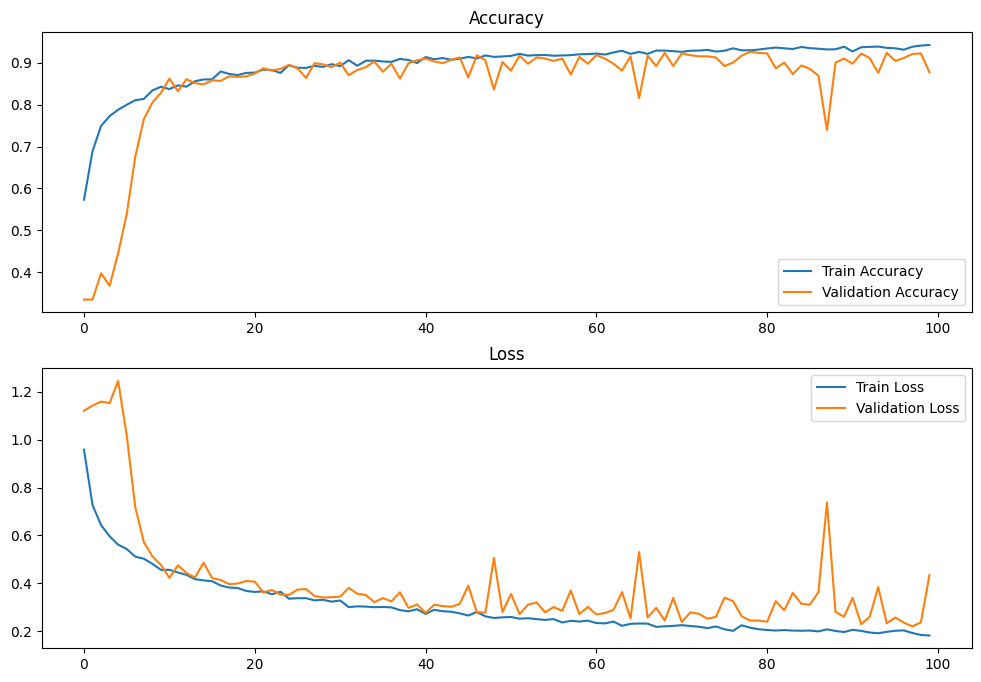

In [178]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history_RN.history['accuracy'], label='Train Accuracy')
plt.plot(history_RN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_RN.history['loss'], label='Train Loss')
plt.plot(history_RN.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


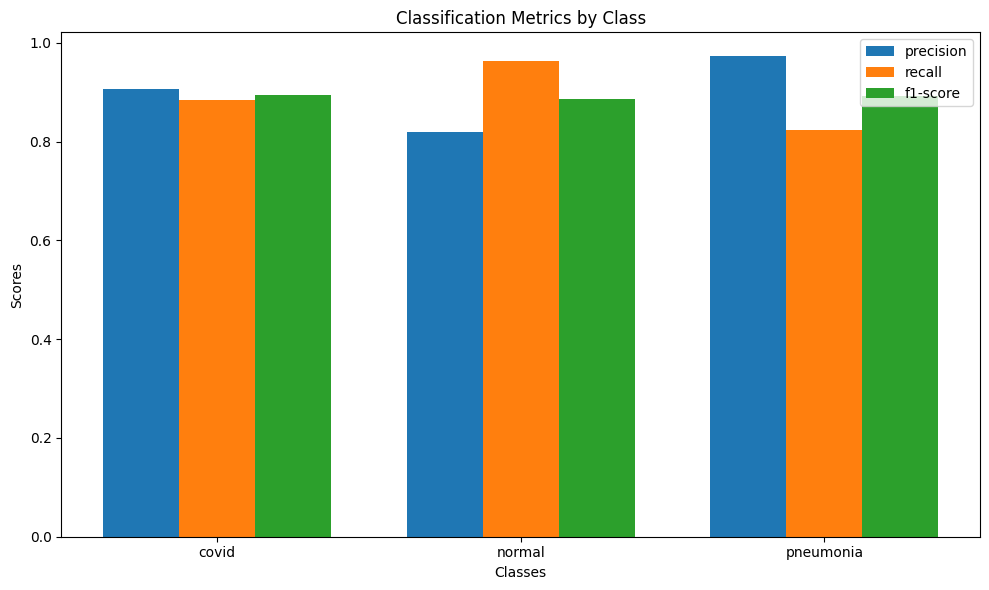

In [179]:
y_pred = model_RN.predict(test_images_res)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.array(test_images_res.classes)

report = classification_report(y_true, y_pred, target_names=['covid', 'normal', 'pneumonia'], output_dict=True)
classes = ['covid', 'normal', 'pneumonia']
metrics = ['precision', 'recall', 'f1-score']
metrics_values = {metric: [] for metric in metrics}

for metric in metrics:
    for cls in classes:
        metrics_values[metric].append(report[cls][metric])

x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    bars = ax.bar(x + i * width, metrics_values[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [180]:
#history = model.fit(x_train, y_train, epochs=10)

hist_RN = pd.DataFrame(history_RN.history) 

hist_RN_csv = 'history_RN_pad.csv'
with open(hist_RN_csv, mode='w') as f:
    hist_RN.to_csv(f)

# Models comparison

In [182]:
CNN_res_DA = pd.read_csv('/kaggle/working/history_CNN_res.csv')
DN_res_DA = pd.read_csv('/kaggle/working/history_DN_res_1.csv')
RN_res_DA = pd.read_csv('/kaggle/working/history_RN_res.csv')

CNN_pad_DA = pd.read_csv('/kaggle/working/history_CNN.csv')
DN_pad_DA = pd.read_csv('/kaggle/working/history_DN_pad_1.csv')
RN_pad_DA = pd.read_csv('/kaggle/working/history_RN_pad.csv')



In [188]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(RN_pad_DA)

In [192]:
CNN_pad_DA.head()

,Unnamed: 0,Precision,Recall,accuracy,auc_17,loss,val_Precision,val_Recall,val_accuracy,val_auc_17,val_loss
0,0,0.397743,0.397199,0.397541,0.564707,7.874966,0.559110,0.549180,0.557377,0.742136,1.832534
1,1,0.527013,0.516393,0.523907,0.693278,2.650160,0.608631,0.558743,0.598361,0.784870,1.088421
2,2,0.563895,0.500342,0.545424,0.726258,1.388610,0.635009,0.465847,0.583333,0.791837,0.902629
3,3,0.614910,0.476093,0.568989,0.760204,1.000208,0.700000,0.478142,0.617486,0.811726,0.826042
4,4,0.634761,0.430328,0.580260,0.766916,0.953770,0.728033,0.475410,0.666667,0.837261,0.774356


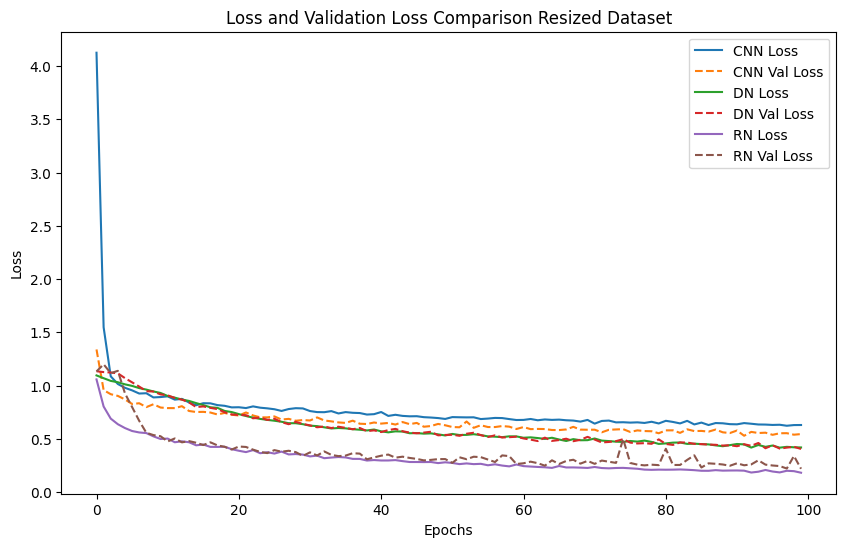

In [193]:
plt.figure(figsize=(10, 6))
plt.plot(CNN_res_DA['Unnamed: 0'], CNN_res_DA['loss'], label='CNN Loss')
plt.plot(CNN_res_DA['Unnamed: 0'], CNN_res_DA['val_loss'], label='CNN Val Loss', linestyle='dashed')
plt.plot(DN_res_DA['Unnamed: 0'], DN_res_DA['loss'], label='DN Loss')
plt.plot(DN_res_DA['Unnamed: 0'], DN_res_DA['val_loss'], label='DN Val Loss', linestyle='dashed')
plt.plot(RN_res_DA['Unnamed: 0'], RN_res_DA['loss'], label='RN Loss')
plt.plot(RN_res_DA['Unnamed: 0'], RN_res_DA['val_loss'], label='RN Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss and Validation Loss Comparison Resized Dataset')
plt.legend()
plt.show()


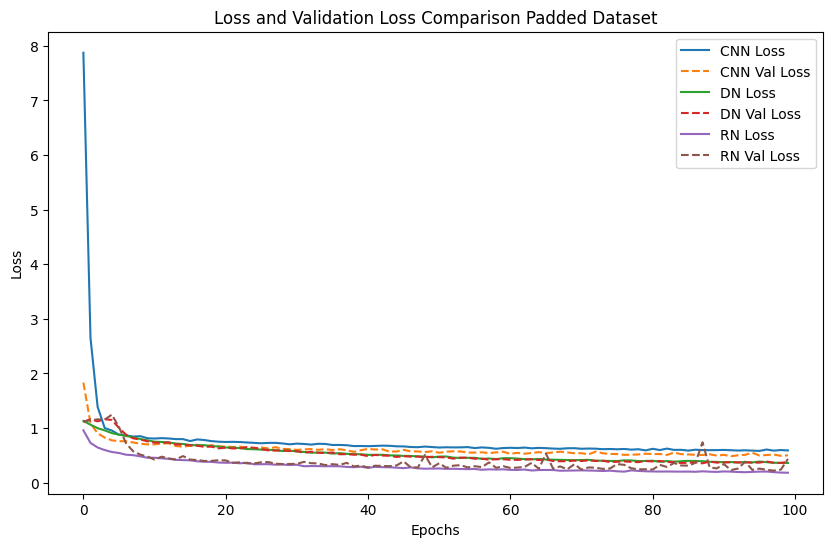

In [194]:
plt.figure(figsize=(10, 6))
plt.plot(CNN_pad_DA['Unnamed: 0'], CNN_pad_DA['loss'], label='CNN Loss')
plt.plot(CNN_pad_DA['Unnamed: 0'], CNN_pad_DA['val_loss'], label='CNN Val Loss', linestyle='dashed')
plt.plot(DN_pad_DA['Unnamed: 0'], DN_pad_DA['loss'], label='DN Loss')
plt.plot(DN_pad_DA['Unnamed: 0'], DN_pad_DA['val_loss'], label='DN Val Loss', linestyle='dashed')
plt.plot(RN_pad_DA['Unnamed: 0'], RN_pad_DA['loss'], label='RN Loss')
plt.plot(RN_pad_DA['Unnamed: 0'], RN_pad_DA['val_loss'], label='RN Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss and Validation Loss Comparison Padded Dataset')
plt.legend()
plt.show()


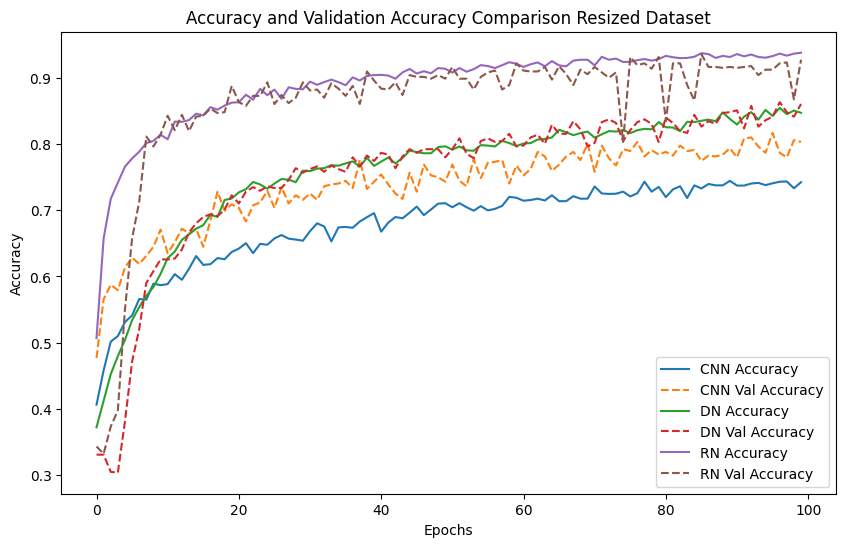

In [195]:
plt.figure(figsize=(10, 6))

plt.plot(CNN_res_DA['Unnamed: 0'], CNN_res_DA['accuracy'], label='CNN Accuracy')
plt.plot(CNN_res_DA['Unnamed: 0'], CNN_res_DA['val_accuracy'], label='CNN Val Accuracy', linestyle='dashed')
plt.plot(DN_res_DA['Unnamed: 0'], DN_res_DA['accuracy'], label='DN Accuracy')
plt.plot(DN_res_DA['Unnamed: 0'], DN_res_DA['val_accuracy'], label='DN Val Accuracy', linestyle='dashed')
plt.plot(RN_res_DA['Unnamed: 0'], RN_res_DA['accuracy'], label='RN Accuracy')
plt.plot(RN_res_DA['Unnamed: 0'], RN_res_DA['val_accuracy'], label='RN Val Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy and Validation Accuracy Comparison Resized Dataset')
plt.legend()
plt.show()


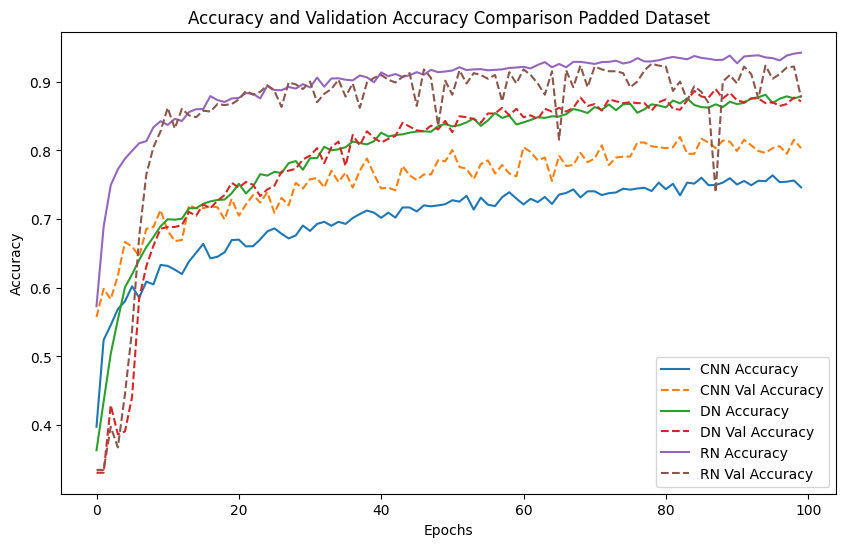

In [196]:
plt.figure(figsize=(10, 6))

plt.plot(CNN_pad_DA['Unnamed: 0'], CNN_pad_DA['accuracy'], label='CNN Accuracy')
plt.plot(CNN_pad_DA['Unnamed: 0'], CNN_pad_DA['val_accuracy'], label='CNN Val Accuracy', linestyle='dashed')
plt.plot(DN_pad_DA['Unnamed: 0'], DN_pad_DA['accuracy'], label='DN Accuracy')
plt.plot(DN_pad_DA['Unnamed: 0'], DN_pad_DA['val_accuracy'], label='DN Val Accuracy', linestyle='dashed')
plt.plot(RN_pad_DA['Unnamed: 0'], RN_pad_DA['accuracy'], label='RN Accuracy')
plt.plot(RN_pad_DA['Unnamed: 0'], RN_pad_DA['val_accuracy'], label='RN Val Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy and Validation Accuracy Comparison Padded Dataset')
plt.legend()
plt.show()


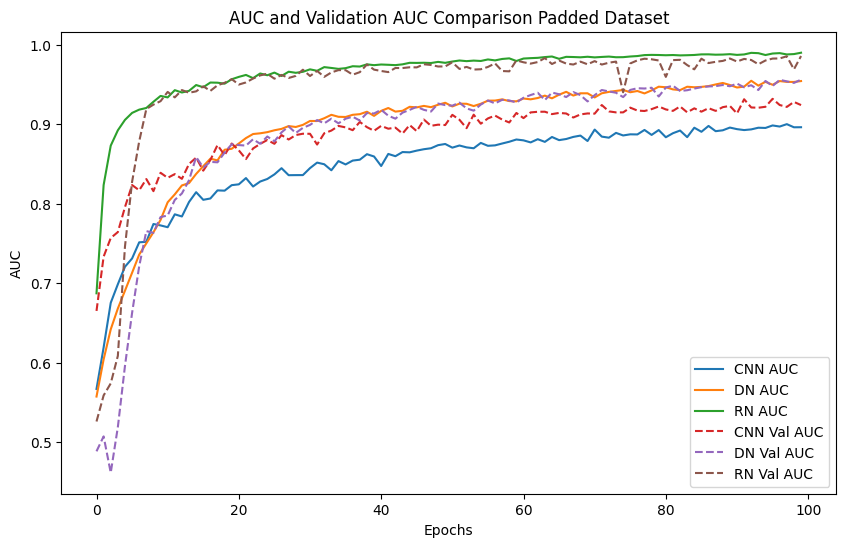

In [197]:
plt.figure(figsize=(10, 6))

plt.plot(CNN_res_DA['Unnamed: 0'], CNN_res_DA['auc_14'], label='CNN AUC')
plt.plot(DN_res_DA['Unnamed: 0'], DN_res_DA['auc_15'], label='DN AUC')
plt.plot(RN_res_DA['Unnamed: 0'], RN_res_DA['auc_16'], label='RN AUC')

plt.plot(CNN_res_DA['Unnamed: 0'], CNN_res_DA['val_auc_14'], label='CNN Val AUC', linestyle='dashed')
plt.plot(DN_res_DA['Unnamed: 0'], DN_res_DA['val_auc_15'], label='DN Val AUC', linestyle='dashed')
plt.plot(RN_res_DA['Unnamed: 0'], RN_res_DA['val_auc_16'], label='RN Val AUC', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('AUC and Validation AUC Comparison Padded Dataset')
plt.legend()
plt.show()


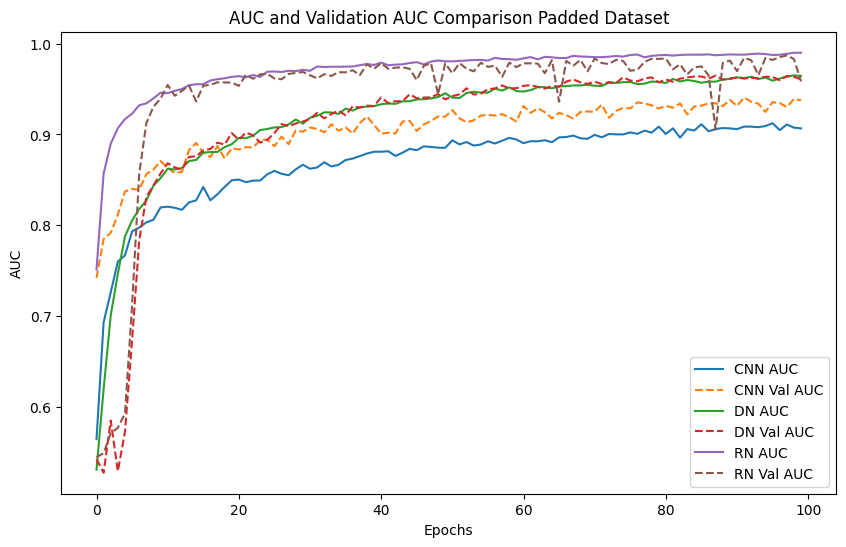

In [202]:
plt.figure(figsize=(10, 6))

plt.plot(CNN_pad_DA['Unnamed: 0'], CNN_pad_DA['auc_17'], label='CNN AUC')
plt.plot(CNN_pad_DA['Unnamed: 0'], CNN_pad_DA['val_auc_17'], label='CNN Val AUC', linestyle='dashed')
plt.plot(DN_pad_DA['Unnamed: 0'], DN_pad_DA['auc_18'], label='DN AUC')
plt.plot(DN_pad_DA['Unnamed: 0'], DN_pad_DA['val_auc_18'], label='DN Val AUC', linestyle='dashed')
plt.plot(RN_pad_DA['Unnamed: 0'], RN_pad_DA['auc_19'], label='RN AUC')
plt.plot(RN_pad_DA['Unnamed: 0'], RN_pad_DA['val_auc_19'], label='RN Val AUC', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('AUC and Validation AUC Comparison Padded Dataset')
plt.legend()
plt.show()


# DEMO

In [39]:
model_1 = load_model('/kaggle/input/cnn/keras/default/1/model_CNN (1).h5')
model_2 = load_model('/kaggle/input/model_dn.h5/keras/default/1/model_DN.h5')
model_3 = load_model('/kaggle/input/resnet/keras/default/1/model_RN_SGD.h5')

In [45]:
scores = model_1.evaluate(test_images_res, verbose=1)
print(f'Score: {model_1.metrics_names[0]} of {scores[0]}; {model_1.metrics_names[1]} of {scores[1]*100}%')

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 429ms/step - accuracy: 0.8415 - loss: 112.7325
Score: loss of 119.86260986328125; compile_metrics of 83.71584415435791%


In [43]:
label_names = {0: 'normal', 1: 'covid', 2: 'pneumonia'}

models = {
    'CNN': model_1,
    #'DenseNet': model_2,
    'ResNet': model_3
}

test_x, test_y = next(test_images_res)

def DEMO(model, model_name):
    print(f"\nEvaluating {model_name}...")
    start_time = time.time()
    y_pred = np.argmax(model.predict(test_x, batch_size=32, verbose=True), axis=1)
    end_time = time.time()
    true_labels = np.argmax(test_y, axis=1)
    for i in random.sample(range(len(test_x)), 4):
        print("\nImage number: " + str(i))
        print("True Label: " + label_names[true_labels[i]])
        print("Predicted Label: " + label_names[y_pred[i]])
    print(f"\nTime Taken for Prediction: {end_time - start_time} seconds")
    print(f"Model Complexity: {model.count_params()} parameters")

for model_name, model in models.items():
    DEMO(model, model_name)



Evaluating CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step

Image number: 27
True Label: pneumonia
Predicted Label: normal

Image number: 3
True Label: pneumonia
Predicted Label: pneumonia

Image number: 11
True Label: pneumonia
Predicted Label: pneumonia

Image number: 1
True Label: covid
Predicted Label: covid

Time Taken for Prediction: 0.4786081314086914 seconds
Model Complexity: 11168771 parameters

Evaluating ResNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step

Image number: 20
True Label: covid
Predicted Label: normal

Image number: 1
True Label: covid
Predicted Label: normal

Image number: 0
True Label: pneumonia
Predicted Label: normal

Image number: 27
True Label: pneumonia
Predicted Label: normal

Time Taken for Prediction: 0.29717087745666504 seconds
Model Complexity: 628227 parameters
